<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/8_NLP_Basics/NLP2_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Attention is all you need!



- We're going to open the black box of modern NLP.

- RNNs and LSTMs sequential nature, while intuitive, becomes a bottleneck for training on the massive datasets required for true language understanding.

- In 2017, the paper [**"Attention Is All You Need"**](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) changed everything. It introduced the **Transformer**, an architecture that processes all words in a sentence at once, using a powerful mechanism called **self-attention**.


---
## The Core Idea - Self-Attention

- Imagine the sentence: *"The robot picked up the ball because **it** was heavy."*

- What does **"it"** refer to? The robot or the ball? As humans, we know "it" refers to the ball. For a model to understand this, the representation for the word "it" needs to be informed by the representations of "robot" and "ball".

- **Self-attention** is the mechanism that allows a model to weigh the importance of other words in the input sequence when processing a specific word. It learns to create context-aware embeddings by looking at the entire sentence at once.

### The Q, K, V Analogy

To achieve this, self-attention creates three vectors from each word's initial embedding:

- **Query (Q):** What I'm looking for. This vector represents the current word asking a question, like "Who am I related to?"
- **Key (K):** What I have. This vector represents a word's "label" or key, which other words can match against. It says, "This is what I am."
- **Value (V):** What I'm actually worth. This vector is the actual content of the word.

The process works like this:

1.  For the word we are currently processing (e.g., "it"), its **Query** vector is compared against every other word's **Key** vector in the sentence.

2.  This comparison results in an **attention score** (a number), indicating how relevant each word is to "it". A high score means high relevance.

3.  These scores are then used to create a weighted sum of all the **Value** vectors. Words with high scores contribute more to the final representation of "it".

So, the model learns that the Query for "it" strongly matches the Key for "ball", and thus the Value of "ball" is heavily weighted into the new, context-aware representation of "it".


![attention](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*qN2Pj5J4VqAFf7dsA2dHpA.png?raw=1)

### The Math: Scaled Dot-Product Attention

This entire process is captured in a single, elegant equation:

$$ \Large \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Let's break this down:
1.  **$QK^T$**: We compute the dot product between the Query matrix and the transpose of the Key matrix. This calculates the attention scores for every word against every other word in one go.
2.  **$/ \sqrt{d_k}$**: We scale the scores by the square root of the dimension of the key vectors ($d_k$). This is crucial for numerical stability. Without it, the dot products can grow very large for large $d_k$, pushing the softmax function into regions with tiny gradients, making learning difficult.
3.  **softmax()**: We apply a softmax function to the scaled scores. This turns the scores into a probability distribution (they sum to 1.0), representing the weights for each word's value.
4.  **$V$**: We multiply this weight matrix by the Value matrix. This creates the final output—a new set of embeddings where each word's representation is a weighted sum of all other words' values.

### Implementing Self-Attention in Keras

 We'll create a custom Keras layer for a single attention head.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
import numpy as np

class SelfAttention(Layer):
    def __init__(self, embed_dim, head_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.head_dim = head_dim

        # Check to ensure head_dim is a divisor of embed_dim
        if embed_dim % head_dim != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by head dimension = {head_dim}"
            )

        # Dense layers to project input embeddings into Q, K, V
        self.query_layer = Dense(head_dim, use_bias=False)
        self.key_layer = Dense(head_dim, use_bias=False)
        self.value_layer = Dense(head_dim, use_bias=False)

    def call(self, inputs):
        # inputs are expected to have shape (batch_size, seq_length, embed_dim)

        # 1. Project inputs into Q, K, V
        query = self.query_layer(inputs)  # Shape: (batch_size, seq_length, head_dim)
        key = self.key_layer(inputs)    # Shape: (batch_size, seq_length, head_dim)
        value = self.value_layer(inputs)  # Shape: (batch_size, seq_length, head_dim)

        # 2. Calculate attention scores: QK^T
        # We need to transpose the key matrix on its last two dimensions
        # tf.matmul handles batch matrix multiplication automatically
        scores = tf.matmul(query, key, transpose_b=True) # Shape: (batch_size, seq_length, seq_length)

        # 3. Scale the scores
        d_k = tf.cast(tf.shape(key)[-1], tf.float32) # Get head_dim as float
        scaled_scores = scores / tf.math.sqrt(d_k)

        # 4. Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1) # Shape: (batch_size, seq_length, seq_length)

        # 5. Multiply weights by V to get the final output
        output = tf.matmul(attention_weights, value) # Shape: (batch_size, seq_length, head_dim)

        return output

# Let's test it with some dummy data
batch_size = 4
seq_length = 10
embed_dim = 128
head_dim = 64 # Dimension of Q, K, V for a single head

dummy_input = tf.random.normal((batch_size, seq_length, embed_dim))

attention_layer = SelfAttention(embed_dim, head_dim)
output_tensor = attention_layer(dummy_input)

print("Input shape:", dummy_input.shape)
print("Output shape:", output_tensor.shape)

Input shape: (4, 10, 128)
Output shape: (4, 10, 64)


---
## Multi-Head Attention

The authors found that it's more powerful to have multiple attention mechanisms, or **"heads"**, running in parallel. This is called **Multi-Head Attention**.

![multihead](https://aiml.com/wp-content/uploads/2023/09/Self-Attention-vs-Multi-headed-Attention.png?raw=1)

**Intuition:** One attention head might learn to track syntactic relationships (e.g., subject-verb agreement), while another might track semantic relationships (e.g., what "it" refers to). Each head looks at the input sentence through a different "lens".

The process is simple:
1.  Split the initial embedding dimension into `N` heads. For example, a 768-dim embedding could be split into 12 heads of 64-dim each.
2.  Run the self-attention mechanism independently for each head in parallel.
3.  Concatenate the outputs of all heads.
4.  Pass the concatenated result through a final dense layer to produce the final output.

In [ ]:
class MultiHeadAttention(Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )

        self.head_dim = embed_dim // num_heads

        # Create a list of attention heads
        self.attention_heads = [SelfAttention(embed_dim, self.head_dim) for _ in range(num_heads)]

        # A final dense layer to combine the outputs of the heads
        self.output_layer = Dense(embed_dim)

    def call(self, inputs):
        # 1. & 2. Run each attention head in parallel
        head_outputs = [head(inputs) for head in self.attention_heads]

        # 3. Concatenate the outputs
        concatenated_heads = tf.concat(head_outputs, axis=-1) # Shape: (batch_size, seq_length, embed_dim)

        # 4. Pass through the final dense layer
        multi_head_output = self.output_layer(concatenated_heads)

        return multi_head_output

# Let's test it
num_heads = 8

mha_layer = MultiHeadAttention(embed_dim, num_heads)
mha_output = mha_layer(dummy_input)

print("Input shape:", dummy_input.shape)
print("Multi-Head Attention output shape:", mha_output.shape)

Input shape: (4, 10, 128)
Multi-Head Attention output shape: (4, 10, 128)


---
##  The Full Encoder Block


The Multi-Head Attention layer is just one part of a full Transformer Encoder block. Two other crucial components are:

1.  **Feed-Forward Network (FFN):** A simple two-layer fully connected network applied to each position's representation independently. This adds more learnable parameters and modeling capacity.
2.  **Residual Connections & Layer Normalization:**
   - **Residual Connection:** The input to a sub-layer (like MHA) is added to its output (`x + Sublayer(x)`). This is vital for training very deep networks, as it allows gradients to flow more easily.
   - [**Layer Normalization:**](https://keras.io/api/layers/normalization_layers/layer_normalization/) This normalizes the features for each token across its embedding dimension. It helps stabilize the learning process.
   
The flow of a single Encoder Block is:
`Input -> Multi-Head Attention -> Add & Norm -> Feed-Forward Network -> Add & Norm -> Output`

![encoderAtt](https://miro.medium.com/v2/resize:fit:876/format:webp/1*7sjcgd_nyODdLbZSxyxz_g.png?raw=1)


In [ ]:
from tensorflow.keras.layers import LayerNormalization, Add

class EncoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ffn_dim, dropout_rate=0.1):
        super(EncoderBlock, self).__init__()

        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ffn_dim, activation="relu"),
            Dense(embed_dim)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # --- First sub-layer: Multi-Head Attention --- #
        attn_output = self.mha(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        # Residual connection and layer normalization
        out1 = self.layernorm1(inputs + attn_output)

        # --- Second sub-layer: Feed-Forward Network --- #
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Residual connection and layer normalization
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Test the full block
ffn_dim = 256 # Intermediate dimension for the FFN
encoder_block = EncoderBlock(embed_dim, num_heads, ffn_dim)
encoder_output = encoder_block(dummy_input)

print("Input shape:", dummy_input.shape)
print("Encoder Block output shape:", encoder_output.shape)

Input shape: (4, 10, 128)
Encoder Block output shape: (4, 10, 128)


---
## Positional Encodings - The Missing Piece

There's one final problem. Our attention mechanism is **permutation invariant**. If you shuffle the words in a sentence, it will produce almost the same output because it doesn't have an inherent sense of order. But for language, word order is everything! *"The dog bit the man"* is very different from *"The man bit the dog"*.

The solution is to add a vector to each input embedding that explicitly encodes its position in the sequence. This is the **Positional Encoding**. The authors used a clever trick with sine and cosine functions:

$$ PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$
$$ PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) $$

Where:
- `pos` is the position of the word in the sequence (0, 1, 2, ...).
- `i` is the dimension within the embedding vector (0, 1, 2, ...).
- `d_model` is the total embedding dimension.

This creates a unique, non-repeating vector for each position that the model can learn to interpret.
Let's visualize them!

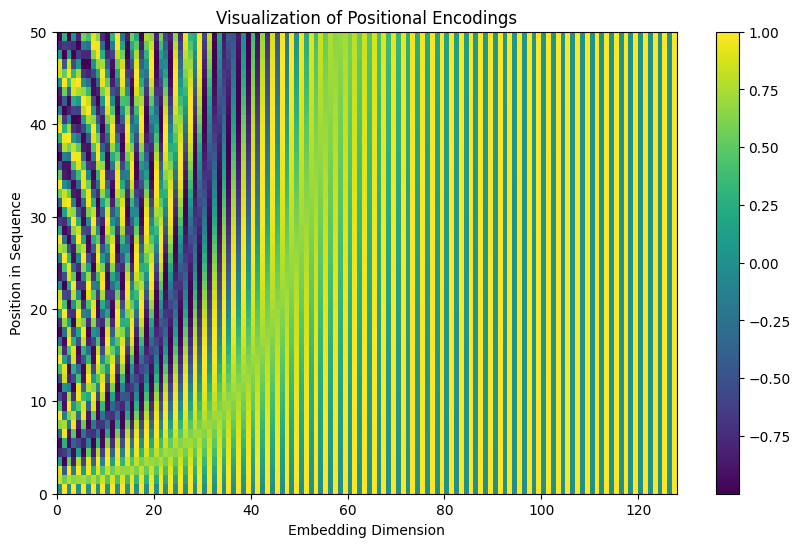

In [ ]:
import matplotlib.pyplot as plt

def get_positional_encoding(max_seq_len, d_model):
    # Create a matrix of positions and dimensions
    position = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    # Initialize the positional encoding matrix
    pe = np.zeros((max_seq_len, d_model))

    # Apply sin to even indices
    pe[:, 0::2] = np.sin(position * div_term)

    # Apply cos to odd indices
    pe[:, 1::2] = np.cos(position * div_term)

    return tf.constant(pe, dtype=tf.float32)

# Visualize the positional encodings
max_seq_len_viz = 50
d_model_viz = 128

pos_encoding = get_positional_encoding(max_seq_len_viz, d_model_viz)

plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.xlim((0, d_model_viz))
plt.ylabel('Position in Sequence')
plt.colorbar()
plt.title('Visualization of Positional Encodings')
plt.show()

You can see how each row (position) has a unique sinusoidal pattern. This is what the model uses to understand word order.

---

## Conclusion


We have learned:
1.  **Self-Attention** is a mechanism for creating context-aware embeddings by weighing the importance of all words in a sequence.
2.  The **Q, K, V** formulation allows this weighing to be learned and executed efficiently with matrix multiplication.
3.  **Multi-Head Attention** allows the model to focus on different types of relationships simultaneously.
4.  **Positional Encodings** inject the crucial information about word order into the model.
5.  An **Encoder Block** combines these elements with residual connections and layer normalization to create a powerful, stable, and trainable unit.

Models like **BERT** are essentially just a stack of these Encoder Blocks. By understanding this single block, you understand the core of what makes modern NLP possible.